<a href="https://colab.research.google.com/github/rpezoa/Intro_XAI/blob/main/14_MC_Dropout_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Parámetros Estelares usando MC Dropout


* Las estrellas másivas son aquellas que tienen una masa superior a 8 masas solares.  Masa solar $≈  2 \times 10^{30}kg$, temperaturas $\geq 10.000 K$

* El análisis de estrellas masivas permite estudiar sus propiedades de pulsación y pérdida de masa, fundamentales para la comprensión de la evolución estelar y galáctica.

* Una tarea muy importante, es la estimación de parámetros estelares y de viento.

* Algunos de los parámetros estelares son: velocidad de rotación ($v\, sin i$), logaritmo de la gravedad ( $\log\,g$,), temperatura efectiva ($T_{\mathrm{eff}}$)

En este notebook se realizará un análisis simple para estimar $v sin i$,  $\log\,g$, y $T_{\mathrm{eff}}$


* Más sobre estrellas masivas en: https://massivestars.ifa.uv.cl/

## Ejemplo de línea espectral de estrella masiva observada
* Imagen obtenida del artículo: Arcos, C., Kanaan, S., Chávez, J., Vanzi, L., Araya, I., & Curé, M. (2018). Stellar parameters and H α line profile variability of Be stars in the BeSOS survey. Monthly Notices of the Royal Astronomical Society, 474(4), 5287-5299.  [Link](https://academic.oup.com/mnras/article/474/4/5287/4788120).
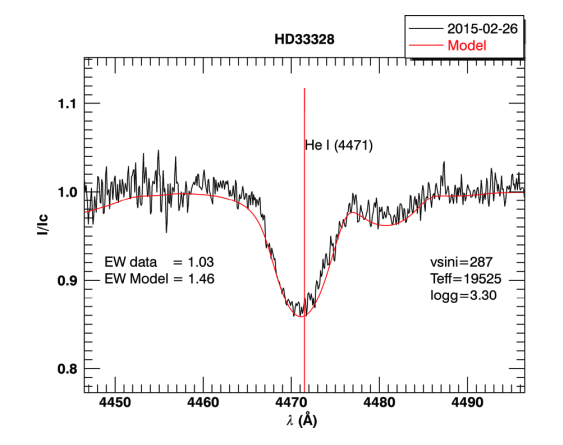

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## Descarga de líneas espectrales

In [4]:
!gdown https://drive.google.com/uc?id=1m_GajQqDRcKrH8_ExG_0Yp_sQ4MrhZbN

Downloading...
From: https://drive.google.com/uc?id=1m_GajQqDRcKrH8_ExG_0Yp_sQ4MrhZbN
To: /content/df_ZPEKTR_limb_lineal.csv
100% 19.1M/19.1M [00:00<00:00, 84.0MB/s]


## Líneas espectrales sintéticas
***

* Acá, cargamos directamente un dataframe, generado por Daniela Turis, estudiante de Doctorado en Astrofísica (IFA-UV)
* El dataframe contiene 10691 líneas, y 188 columnas.
* Columnas con índice 0 a 169 corresponde a 169 puntos de flujos de la línea espectral
* Columnas con índice 170 a 175 son parámetros estelares de entrada
* Columnas con índice 176 a 179
y_input = df.iloc[:,170:176] # input parameters
y_output = df.iloc[:,176:] # output parameters

* Columnas con índice 176, 177 y 178: Teff, logg, vsini

## Notar que solo predeciremos la temperatura efectiva

In [5]:
# Paso 2: Cargar datos
df = pd.read_csv("df_ZPEKTR_limb_lineal.csv")

# Paso 3: Seleccionar variables
X = df.iloc[:, 0:170].values.astype(np.float32)  # espectros
y = df.iloc[:, 176:177].values.astype(np.float32)  # primer parámetro de salida


# Paso 4: Normalizar
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("X_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)

X_scaled shape: (10691, 170)
y_scaled shape: (10691, 1)


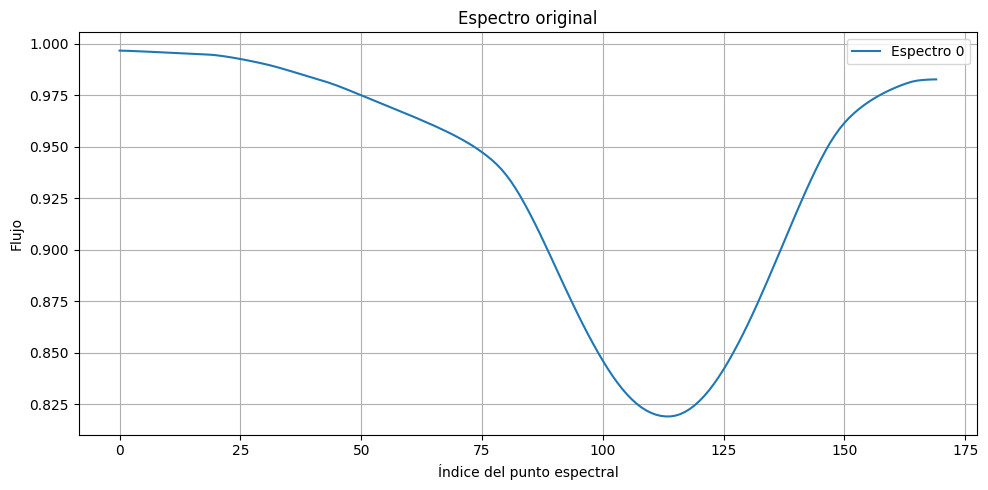

In [6]:
# Graficar un espectro original (sin escalar)
indice = 0  # cambia este valor para ver otros espectros
espectro_original = df.iloc[indice, 0:170].values
longitudes_onda = np.arange(170)  # si no tienes el eje de longitud de onda, puedes usar el índice

plt.figure(figsize=(10,5))
plt.plot(longitudes_onda, espectro_original, label=f'Espectro {indice}')
plt.xlabel("Índice del punto espectral")
plt.ylabel("Flujo")
plt.title("Espectro original")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Arquitectura de la red usando MC Dropout

In [7]:
class MCDropoutRegressor(nn.Module): # hereda de nn.Module, usado para regresión
    def __init__(self, input_dim):
        super(MCDropoutRegressor, self).__init__() # 6 capas densas
        # Se define qué capas usar (pero no las aplicas todavía).
        # Definición de capas como objetos de PyTorch (nn.Linear, nn.Dropout).
        # No hay transformación aquí todavía. Solo se construyen los bloques del modelo.
        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 200)
        self.out = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x): #Aplica las capas densas intercaladas con activación ReLU y Dropout.
        # Este método dice qué hacer con los datos cuando se pasa por el modelo
        # Notar que en PyTorch, uno controla manualmente el flujo de datos en forward,
        # mientras que en Keras se construye automáticamente por la forma en que conectas las capas.
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        return self.out(x)

# Generación de datos train y testing

In [8]:
# Paso 6: Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convertir a tensores y crear DataLoader
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## Entrenamiento de la red probabilística

In [9]:
model = MCDropoutRegressor(input_dim=170)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

n_epochs = 100
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")



Epoch 1/100, Loss: 0.0453
Epoch 2/100, Loss: 0.0205
Epoch 3/100, Loss: 0.0157
Epoch 4/100, Loss: 0.0136
Epoch 5/100, Loss: 0.0127
Epoch 6/100, Loss: 0.0257
Epoch 7/100, Loss: 0.0102
Epoch 8/100, Loss: 0.0113
Epoch 9/100, Loss: 0.0098
Epoch 10/100, Loss: 0.0129
Epoch 11/100, Loss: 0.0095
Epoch 12/100, Loss: 0.0113
Epoch 13/100, Loss: 0.0090
Epoch 14/100, Loss: 0.0094
Epoch 15/100, Loss: 0.0077
Epoch 16/100, Loss: 0.0067
Epoch 17/100, Loss: 0.0070
Epoch 18/100, Loss: 0.0063
Epoch 19/100, Loss: 0.0071
Epoch 20/100, Loss: 0.0074
Epoch 21/100, Loss: 0.0071
Epoch 22/100, Loss: 0.0065
Epoch 23/100, Loss: 0.0098
Epoch 24/100, Loss: 0.0067
Epoch 25/100, Loss: 0.0059
Epoch 26/100, Loss: 0.0059
Epoch 27/100, Loss: 0.0053
Epoch 28/100, Loss: 0.0058
Epoch 29/100, Loss: 0.0071
Epoch 30/100, Loss: 0.0083
Epoch 31/100, Loss: 0.0073
Epoch 32/100, Loss: 0.0057
Epoch 33/100, Loss: 0.0059
Epoch 34/100, Loss: 0.0052
Epoch 35/100, Loss: 0.0061
Epoch 36/100, Loss: 0.0059
Epoch 37/100, Loss: 0.0053
Epoch 38/1

## Inferencia con MC Dropout para estimar incertidumbre

In [10]:
model.train()  # Este es la clave para activar/forzar Dropout  durante inferencia
T = 50  # número de muestras MC
predictions = []

with torch.no_grad():
    for _ in range(T):
        preds_mc = model(torch.tensor(X_test).to(device))
        predictions.append(preds_mc.cpu().numpy())


predictions = np.array(predictions)  # shape (T, N, 1)
pred_mean = predictions.mean(axis=0)
pred_std = predictions.std(axis=0)

# Reescalar las predicciones
pred_mean_rescaled = scaler_y.inverse_transform(pred_mean)
pred_std_rescaled = pred_std * scaler_y.scale_

# Mostrar algunas predicciones con incertidumbre
for i in range(5):
    print(f"Ejemplo {i+1}: Predicción = {pred_mean_rescaled[i][0]:.2f} ± {pred_std_rescaled[i][0]:.2f}, Real = {scaler_y.inverse_transform(y_test)[i][0]:.2f}")



Ejemplo 1: Predicción = 18494.44 ± 162.53, Real = 18692.00
Ejemplo 2: Predicción = 25349.08 ± 184.89, Real = 25190.00
Ejemplo 3: Predicción = 24568.13 ± 236.61, Real = 24626.00
Ejemplo 4: Predicción = 16779.18 ± 176.29, Real = 16841.00
Ejemplo 5: Predicción = 18789.59 ± 223.83, Real = 18822.00


# Gráficos de resultados

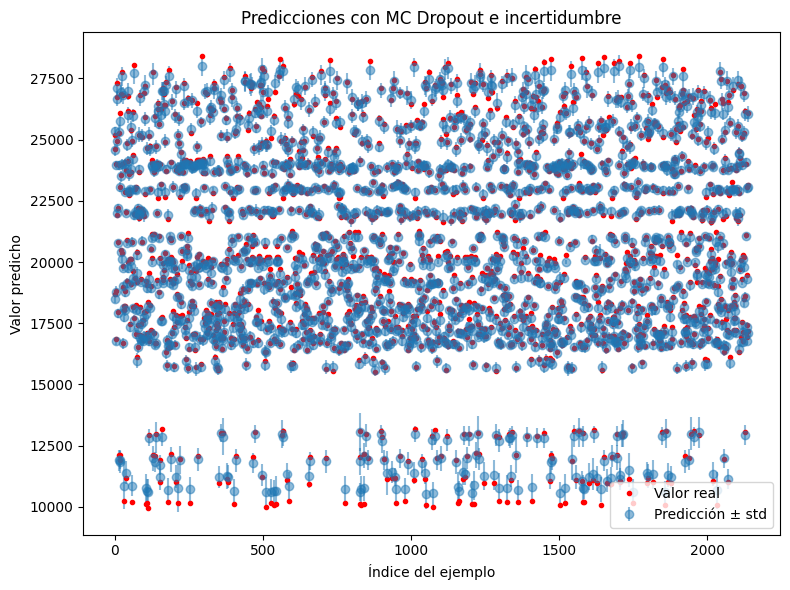

In [11]:
plt.figure(figsize=(8,6))
plt.errorbar(range(len(pred_mean_rescaled)), pred_mean_rescaled.ravel(), yerr=pred_std_rescaled.ravel(), fmt='o', alpha=0.5, label='Predicción ± std')
plt.plot(scaler_y.inverse_transform(y_test), 'r.', label='Valor real')
plt.xlabel('Índice del ejemplo')
plt.ylabel('Valor predicho')
plt.title('Predicciones con MC Dropout e incertidumbre')
plt.legend()
plt.tight_layout()
plt.show()

## Distribuciones predictivas para ejemplos arbitrarios

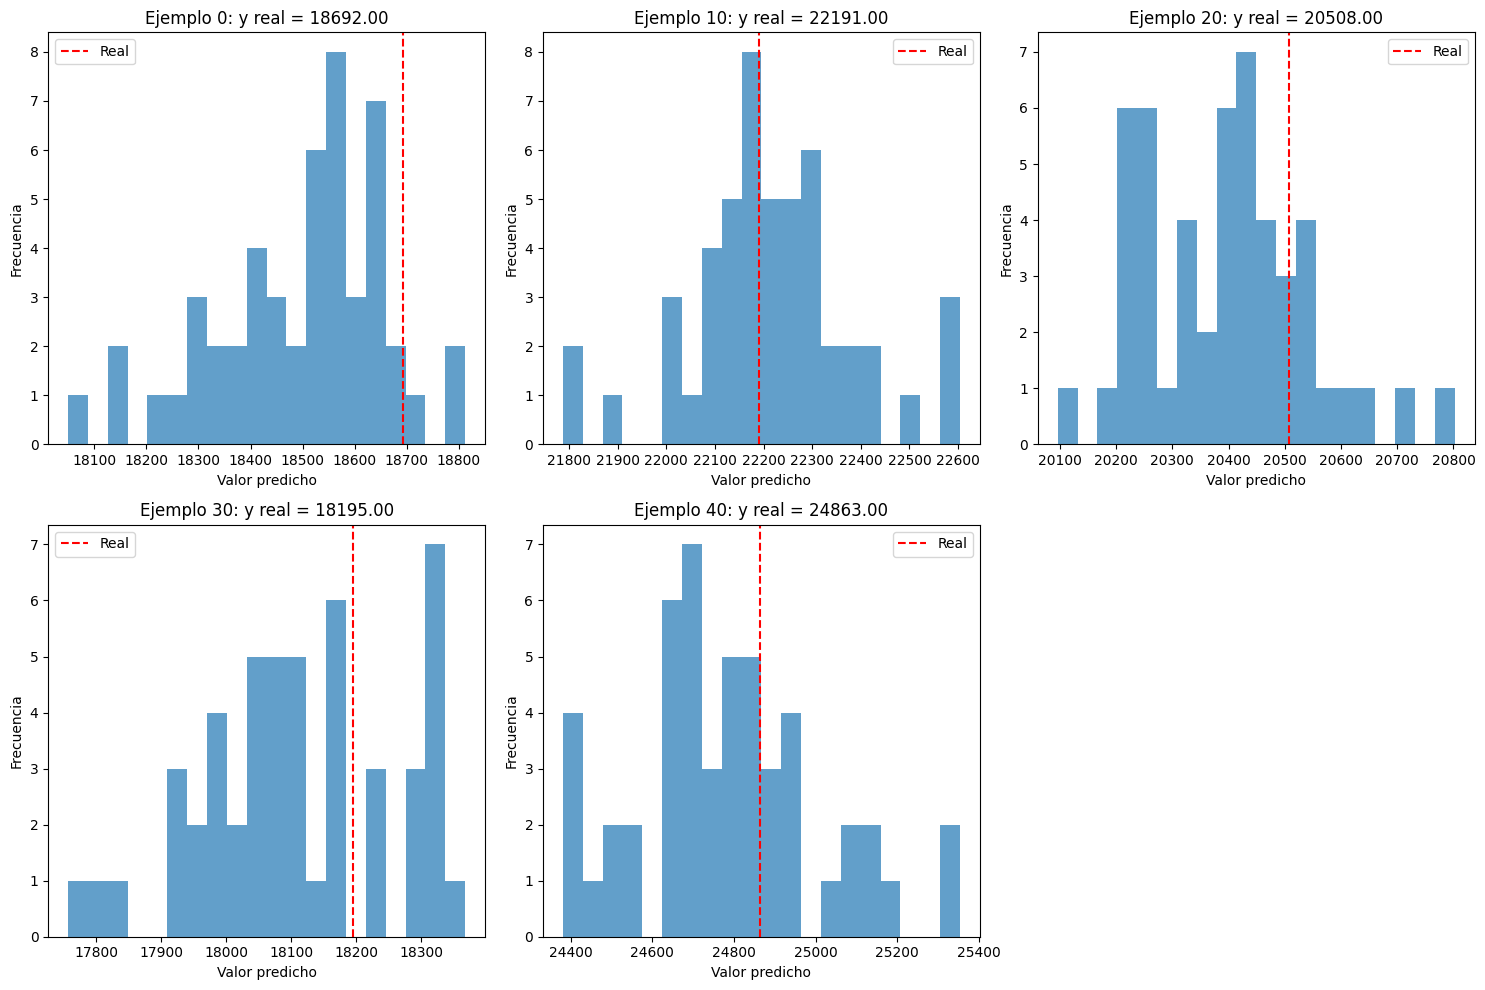

In [12]:

ejemplos = [0, 10, 20, 30, 40]  # índices seleccionados para visualización

plt.figure(figsize=(15, 10))
for i, idx in enumerate(ejemplos):
    plt.subplot(2, 3, i+1)
    plt.hist(predictions[:, idx, 0] * scaler_y.scale_[0] + scaler_y.mean_[0], bins=20, alpha=0.7)
    real_val = scaler_y.inverse_transform(y_test)[idx][0]
    plt.axvline(real_val, color='r', linestyle='dashed', label='Real')
    plt.title(f'Ejemplo {idx}: y real = {real_val:.2f}')
    plt.xlabel('Valor predicho')
    plt.ylabel('Frecuencia')
    plt.legend()
plt.tight_layout()
plt.show()

## Histograma de incertidumbre (desviación estándar y entropía)


Para caracterizar la incertidumbre en las predicciones de nuestro modelo, analizamos dos métricas derivadas de la desviación estándar $\sigma$ de las predicciones obtenidas mediante Monte Carlo Dropout:

- **Desviación estándar**: $$\sigma = \texttt{pred_std_rescaled}$$
  
- **Entropía de una distribución normal**:  
  $$ H(X) = \frac{1}{2} \log\left(2 \pi e \, \sigma^2\right) $$

Donde $H(X)$ representa la entropía diferencial de una variable aleatoria continua $X$ que sigue una distribución normal $N(\mu, \sigma^2)$.

Estas métricas permiten visualizar la cantidad de incertidumbre en las predicciones:
- A mayor $\sigma$, mayor dispersión en las muestras.
- A mayor entropía $H(X)$, mayor incertidumbre epistemológica.

En los histogramas siguientes se muestran las distribuciones de $\sigma$ y $H(X)$ para el conjunto de prueba.


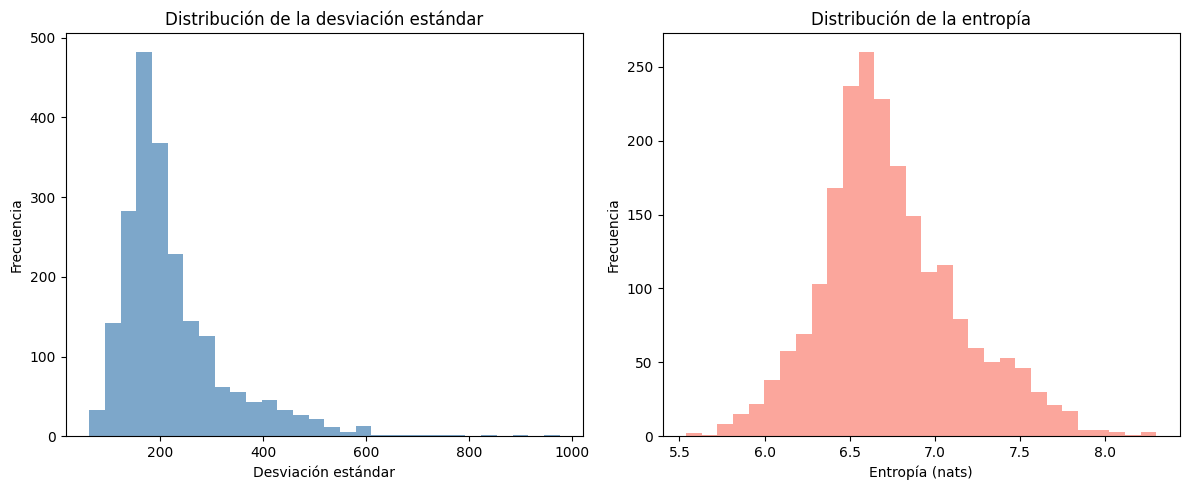

In [15]:
std_dev = pred_std_rescaled.ravel()
entropy = 0.5 * np.log(2 * np.pi * np.e * pred_std_rescaled.ravel()**2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(std_dev, bins=30, color='steelblue', alpha=0.7)
plt.title("Distribución de la desviación estándar")
plt.xlabel("Desviación estándar")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
plt.hist(entropy, bins=30, color='salmon', alpha=0.7)
plt.title("Distribución de la entropía")
plt.xlabel("Entropía (nats)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

### Interpretación de los gráficos

A continuación se presentan dos histogramas:

1. **Distribución de la desviación estándar ($\sigma$)**  
   Muestra cómo varía la dispersión de las predicciones. Valores altos de $\sigma$ indican regiones del espacio de entrada donde el modelo tiene mayor incertidumbre.

2. **Distribución de la entropía ($H(X)$)**  
   Al estar basada en $\sigma$, la entropía proporciona una medida de incertidumbre más informativa desde el punto de vista de la teoría de la información. Valores más altos indican menor confianza del modelo en sus predicciones.

Estos gráficos permiten identificar cuán variable es la incertidumbre entre muestras, y si existen subgrupos con mayor o menor confiabilidad en las predicciones.

## Cálculo de información mutua

Una forma más refinada de cuantificar la incertidumbre epistemológica en modelos bayesianos aproximados como Monte Carlo Dropout es mediante la **información mutua** entre la predicción y los parámetros del modelo.

La información mutua mide **cuánta incertidumbre se reduce** sobre los parámetros del modelo al observar una salida particular. Se calcula como la diferencia entre la entropía predictiva total y la entropía esperada sobre las muestras de Monte Carlo:

- **Entropía esperada** (promedio de la entropía individual de las muestras):
  $$
  \mathbb{E}_{q(\theta)}[H(p(y \mid \mathbf{x}, \theta))] = \frac{1}{T} \sum_{t=1}^T H(p(y \mid \mathbf{x}, \theta_t))
  $$

- **Entropía predictiva total**:
  $$
  H\left(\mathbb{E}_{q(\theta)}[p(y \mid \mathbf{x}, \theta)]\right)
  $$

- **Información mutua**:
  $$
  I[y, \theta \mid \mathbf{x}] = H\left(\mathbb{E}_{q(\theta)}[p(y \mid \mathbf{x}, \theta)]\right) - \mathbb{E}_{q(\theta)}[H(p(y \mid \mathbf{x}, \theta))]
  $$

---


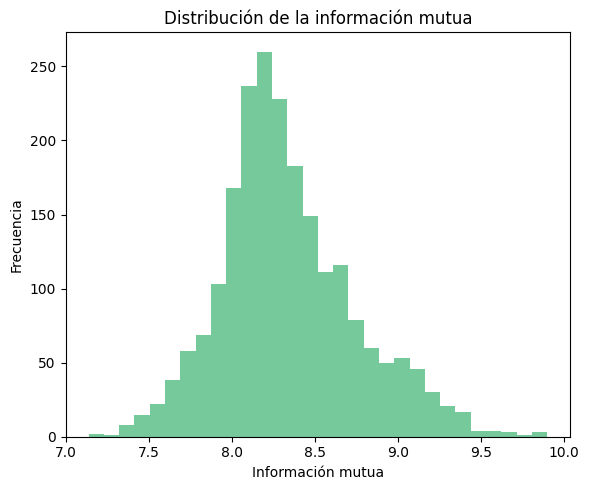

In [16]:
# Entropía esperada
expected_entropy = np.mean(0.5 * np.log(2 * np.pi * np.e * predictions.var(axis=0).ravel()))

# Entropía total
entropy_predictive = 0.5 * np.log(2 * np.pi * np.e * pred_std_rescaled.ravel()**2)
mutual_information = entropy_predictive - expected_entropy

plt.figure(figsize=(6,5))
plt.hist(mutual_information, bins=30, color='mediumseagreen', alpha=0.7)
plt.title("Distribución de la información mutua")
plt.xlabel("Información mutua")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


## Log-verosimilitud negativa (NLL)

La log-verosimilitud negativa (NLL) mide qué tan bien se ajusta la distribución predictiva a los datos observados. Para una distribución normal, está dada por:

NLL(y, μ, σ) = (1/2) · log(2πσ²) + ((y – μ)²)/(2σ²)

Esta métrica combina la incertidumbre (σ) y el error cuadrático entre la predicción (μ) y el valor real (y). Valores más bajos indican mejor ajuste probabilístico. En el siguiente histograma se muestra la distribución de NLL para el conjunto de prueba.


**Notar que estamos suponiendo que la distribución de las salidas sigue una normal.** Las múltiples salidas generadas vía MC Dropout permiten construir una distribución normal empírica (media y varianza estimadas).

Para modelar directamente la distribución, hay que diseñar una red con salida de dos unidades: $[\mu, \log(sigma)]$, y entrenarla usando la NLL gaussiana como función de pérdida. En ese caso, la red aprendería directamente media y varianza condicionales.



In [20]:
# Reescalar y_true (si aún no lo hiciste)
y_true_rescaled = scaler_y.inverse_transform(y_test)

# Aplanar los arrays
mu = pred_mean_rescaled.ravel()
sigma = pred_std_rescaled.ravel() + 1e-6  # evitar división por cero
y = y_true_rescaled.ravel()

# Cálculo de NLL bajo distribución normal
nll = 0.5 * np.log(2 * np.pi * sigma**2) + ((y - mu)**2) / (2 * sigma**2)


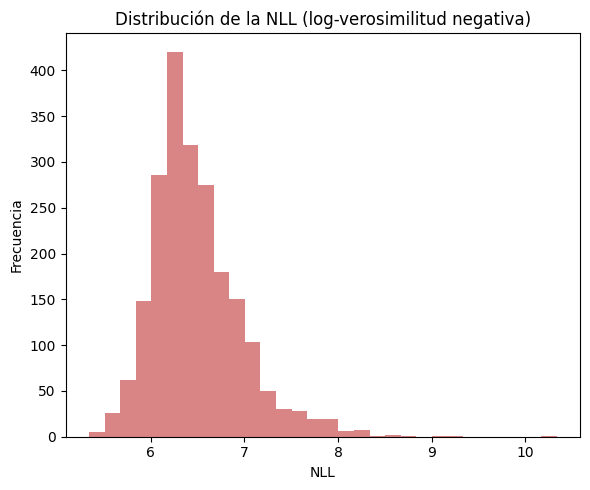

In [21]:
plt.figure(figsize=(6,5))
plt.hist(nll, bins=30, color='indianred', alpha=0.75)
plt.title("Distribución de la NLL (log-verosimilitud negativa)")
plt.xlabel("NLL")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()